In [30]:
from trackml.dataset import load_event
from trackml.dataset import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.preprocessing import LabelEncoder

def proc_arr(x):
    for i in range(len(x) - 1):
        block_stat.ix[x[i], x[i+1]] += 1
        
def proc_arr_next_hit(x):
    for i in range(len(x) - 1):
        next_hits.ix[x[i], 'next_hit'] = x[i+1]

In [2]:
from gensim.models import KeyedVectors
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from keras.layers.merge import concatenate
from keras.layers.wrappers import Bidirectional
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [97]:
def get_cell_stats(cells):
    cell_stats = cells.groupby('hit_id')['value'].mean().reset_index().rename({'value':'value_mean'},axis=1)

    tmp = cells.groupby('hit_id')['value'].max().reset_index().rename({'value':'value_max'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].min().reset_index().rename({'value':'value_min'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].sum().reset_index().rename({'value':'value_sum'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].std().reset_index().rename({'value':'value_std'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')

    tmp = cells.groupby('hit_id')['value'].count().reset_index().rename({'value':'value_count'},axis=1)
    cell_stats = pd.merge(cell_stats, tmp, on='hit_id', how='left')    
    
    cell_cols = list(cell_stats.columns.values[1:])
    return cell_stats

In [101]:
def is_start_hit(truth_hits, particles):
    truth_hits = pd.merge(truth_hits, particles, on='particle_id', how='left')
    truth_hits['to_start'] = (truth_hits['x'] - truth_hits['vx'])**2+(truth_hits['y'] - truth_hits['vy'])**2+(truth_hits['z'] - truth_hits['vz'])**2
    truth_hits = truth_hits.sort_values(['particle_id', 'to_start'])
    tmp = truth_hits.drop_duplicates('particle_id', keep='first')[['particle_id', 'to_start']]
    tmp['target'] = 1
    truth_hits = pd.merge(truth_hits, tmp, on=['particle_id', 'to_start'], how='left')   
    truth_hits.fillna(0, inplace=True)
    return truth_hits['target']

In [102]:
cnt = 0
X_train = pd.DataFrame()
X_val = pd.DataFrame()

for event_id, hits, cells, particles, truth in load_dataset('data/train_5.zip'):
        
    if cnt == 30:
        break
    
    truth_hits = pd.concat([hits, truth.drop(['hit_id'], axis=1)], axis=1)
    truth_hits['dist'] = truth_hits.apply(lambda x: x[1]**2 + x[2]**2 + x[3]**2, axis=1)
    truth_hits['rad_dist'] = truth_hits.apply(lambda x: x[1]**2 + x[2]**2, axis=1)
    
    truth_hits = truth_hits[truth_hits.particle_id != 0].sort_values(['particle_id', 'rad_dist'])
    truth_hits['block'] = truth_hits['volume_id'].astype(str) + "_" + truth_hits['layer_id'].astype(str)
    
    cell_stats = get_cell_stats(cells)
    cell_cols = list(cell_stats.columns.values[1:])
    truth_hits = pd.merge(truth_hits, cell_stats, on='hit_id', how='left')
    
    # Вариант 1
#     truth_hits['idx'] = range(len(truth_hits))
#     tmp = truth_hits.groupby('particle_id')['idx'].min().reset_index().rename({'idx':'idx_min'},axis=1)
#     truth_hits = pd.merge(truth_hits, tmp, on='particle_id', how='left')
#     truth_hits['target'] = truth_hits['idx'] == truth_hits['idx_min']
#     del truth_hits['idx']
#     del truth_hits['idx_min']

    # Вариант 2
    truth_hits['target'] = is_start_hit(truth_hits, particles)
    
    cell_cols = list(cell_stats.columns.values[1:])
    geom_cols = ['x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'dist', 'rad_dist', 'block']
    
    
    X = truth_hits[geom_cols + cell_cols + ['target', 'particle_id']]
    X.dropna(inplace=True)
    del X['block']
    
    #X.drop_duplicates('particle_id', keep='first', inplace=True)    
    del X['particle_id']
    


    if cnt == 0 or cnt == 1:
        X_val = pd.concat([X_val, X], axis=0)
    else:
        X_train = pd.concat([X_train, X], axis=0)
    
    print(cnt)

#     if cnt == 0:
#         break    
    
    cnt += 1

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [103]:
X.shape

(64702, 15)

In [99]:
X

,x,y,z,volume_id,layer_id,module_id,dist,rad_dist,value_mean,value_max,value_min,value_sum,value_std,value_count,target
0,25.112499,19.079800,42.427399,8,2,122,2.794761e+03,994.676373,0.055010,0.078540,0.018366,0.495094,0.026049,9,1.0
1,57.874199,43.973400,93.098297,8,4,276,1.395038e+04,5283.082818,0.053065,0.079045,0.005455,0.477587,0.024624,9,0.0
2,92.384598,70.164803,146.455994,8,6,500,3.490737e+04,13458.013424,0.053934,0.085094,0.018163,0.485402,0.020702,9,0.0
3,136.470993,103.592003,214.587997,8,8,827,7.540364e+04,29355.635000,0.058832,0.080082,0.004247,0.470653,0.024131,8,0.0
4,137.977997,104.731003,216.917999,8,8,828,7.705993e+04,30006.510557,0.045303,0.073837,0.005157,0.453029,0.024717,10,0.0
5,204.522995,155.100006,320.000000,13,2,545,1.682857e+05,65885.667375,1.000000,1.000000,1.000000,3.000000,0.000000,3,0.0
6,289.687012,219.376999,451.000000,13,4,818,3.354458e+05,132044.832406,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0
7,398.040009,301.003998,618.000000,13,6,1296,6.309633e+05,249039.255096,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0
8,403.036011,304.734985,625.799988,13,6,1295,6.469271e+05,255301.437252,1.000000,1.000000,1.000000,1.000000,0.000000,1,0.0
9,527.997986,398.440002,818.000000,13,8,1898,1.106660e+06,437536.308596,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0


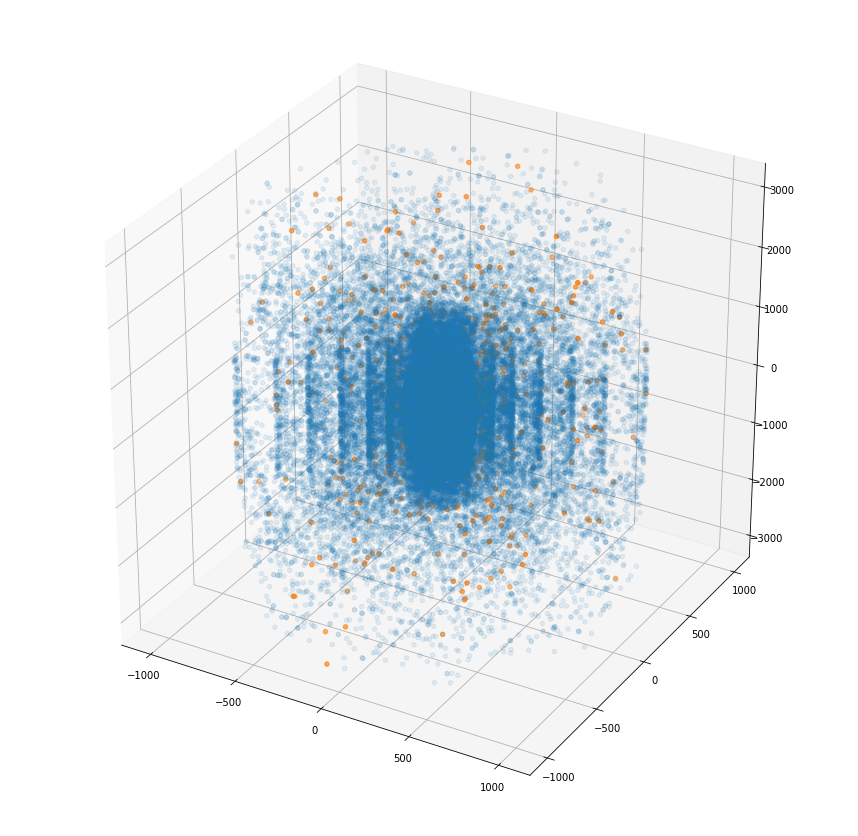

In [104]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
tmp = X[X.target == False]
ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha=0.1)
tmp = X[X.target == True]
ax.scatter(tmp['x'], tmp['y'], tmp['z'])

In [109]:
X['target'].mean()

0.11811072300701679

In [106]:
X_train.shape, X_val.shape

((1944815, 15), (147917, 15))

In [107]:
X_train

,x,y,z,volume_id,layer_id,module_id,dist,rad_dist,value_mean,value_max,value_min,value_sum,value_std,value_count,target
0,9.364960,30.961100,-70.763000,8,2,92,6.053694e+03,1.046292e+03,0.051155,0.069791,0.003011,0.767318,0.020605,15,1.0
1,20.655001,69.188499,-159.526993,8,4,151,3.066254e+04,5.213678e+03,0.050154,0.066363,0.002249,0.702157,0.019246,14,0.0
2,32.586601,110.810997,-255.931000,8,6,193,7.884164e+04,1.334096e+04,0.051876,0.067448,0.019238,0.726261,0.015232,14,0.0
3,47.328098,164.212006,-379.320007,8,8,133,1.730892e+05,2.920553e+04,0.053440,0.075336,0.001484,0.748162,0.018845,14,0.0
4,47.827301,166.072998,-383.605011,8,8,134,1.770205e+05,2.986769e+04,0.050169,0.070216,0.015011,0.752539,0.019248,15,0.0
5,69.783600,250.727997,-578.400024,13,2,189,4.022809e+05,6.773428e+04,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0
6,93.669403,350.313995,-806.000000,13,4,152,7.811299e+05,1.314939e+05,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0
9,174.895996,788.224976,-1797.500000,16,8,71,3.882893e+06,6.518872e+05,1.000000,1.000000,1.000000,2.000000,0.000000,2,0.0
11,12.159400,29.589500,-56.582199,8,2,107,4.224935e+03,1.023390e+03,0.052370,0.079143,0.008670,0.628443,0.023846,12,1.0
12,27.240499,65.687103,-127.304001,8,4,182,2.126315e+04,5.056840e+03,0.051301,0.071653,0.012158,0.615615,0.019526,12,0.0


In [108]:
#%%time
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

scores = []

cat = ['module_id', 'volume_id', 'layer_id']

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['target']  ,axis=1), X_train['target'])

pred = lgb.predict(X_val.drop(['target'],axis=1))#[:,1]


print(accuracy_score( X_val['target'], pred))

0.9720316123231272


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [65]:
#%%time
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

scores = []

cat = ['module_id', 'volume_id', 'layer_id']

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['target']  ,axis=1), X_train['target'])

pred = lgb.predict(X_val.drop(['target'],axis=1))#[:,1]


print(accuracy_score( X_val['target'], pred))

0.9752644148754691


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [81]:
pred = lgb.predict_proba(X_val.drop(['target'],axis=1))[:,1]


print(roc_auc_score( X_val['target'], pred))

0.9691405881072128


In [ ]:
0.9752644148754691

In [ ]:
0.9720316123231272

In [73]:
pred.sum()


16751.0

In [91]:
X_val['pred'] = pred

In [93]:
X_val[X_val.pred == 1]

,x,y,z,volume_id,layer_id,module_id,dist,rad_dist,value_mean,value_max,value_min,value_sum,value_std,value_count,target,pred
9,-23.600700,21.074499,28.903299,8,2,126,1836.528284,1001.127572,0.065150,0.090538,0.019713,0.456051,0.027898,7,1.0,1.0
23,-11.473800,29.294001,41.626999,8,2,125,2722.593590,989.786552,0.057241,0.075697,0.010390,0.515167,0.020359,9,1.0,1.0
34,-29.745899,-10.181200,35.805801,8,2,113,2270.530767,988.475353,0.054063,0.078193,0.005293,0.486569,0.028457,9,1.0,1.0
45,-27.641899,-16.991301,103.037003,8,2,130,11669.402779,1052.778882,0.050555,0.066500,0.001191,1.061660,0.019863,21,1.0,1.0
57,-31.103600,7.588750,-597.500000,7,14,106,358031.273030,1025.023030,0.320444,0.320444,0.320444,0.320444,0.000000,1,1.0,1.0
72,-0.215600,32.275799,817.500000,9,6,85,669348.023671,1041.773671,0.304950,0.304950,0.304950,0.304950,0.000000,1,1.0,1.0
83,1.736360,-31.587299,48.927502,8,2,116,3394.672846,1000.772426,0.057556,0.078634,0.006128,0.575563,0.020202,10,1.0,1.0
93,-10.806600,-30.241400,-56.083500,8,2,99,4176.683817,1031.324855,0.059125,0.073594,0.013645,0.591249,0.019359,10,1.0,1.0
105,-19.680700,-25.965000,-54.654499,8,2,99,4048.625464,1061.511197,0.052742,0.081655,0.008939,0.580162,0.020752,11,1.0,1.0
116,-25.502701,-18.643000,-83.546898,8,2,82,7978.033331,997.949184,0.046815,0.071925,0.003941,0.795860,0.021857,17,1.0,1.0


In [89]:
pred = lgb.predict(X_val.drop(['target', 'pred'],axis=1))

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [96]:
pred

array([0., 0., 0., ..., 0., 0., 0.])

In [74]:
X_val.shape

(199308, 15)

In [75]:
10000*100000

1000000000

In [28]:
pred[:20]

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [29]:
X_val['target'].values[:20]

array([ True, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [ ]:
0.8853540252182347

In [ ]:
0.9568529433708871
0.9566738789823174

In [86]:
imp = pd.DataFrame()
imp['feature'] = X_train.drop(['target'], axis=1).columns.values
imp['importance'] = lgb.feature_importances_
imp = imp.sort_values('importance', ascending=False)
imp.index = range(len(imp))

ValueError: Length of values does not match length of index

In [31]:
imp

,feature,importance
0,rad_dist,5439
1,z,3702
2,dist,3103
3,value_sum,2746
4,x,2536
5,y,2468
6,module_id,2114
7,value_mean,1050
8,value_min,795
9,value_count,783


In [39]:
X.columns.values

array(['x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'dist',
       'rad_dist', 'value_mean', 'value_max', 'value_min', 'value_sum',
       'value_std', 'value_count', 'target', 'fold'], dtype=object)

In [36]:
pd.get_dummies(X_train, columns=['volume_id', 'layer_id'])

,x,y,z,module_id,dist,rad_dist,value_mean,value_max,value_min,value_sum,...,volume_id_16,volume_id_17,volume_id_18,layer_id_2,layer_id_4,layer_id_6,layer_id_8,layer_id_10,layer_id_12,layer_id_14
0,9.364960,30.961100,-70.763000,92,6.053694e+03,1046.292160,0.051155,0.069791,0.003011,0.767318,...,0,0,0,1,0,0,0,0,0,0
1,20.655001,69.188499,-159.526993,151,3.066254e+04,5213.677510,0.050154,0.066363,0.002249,0.702157,...,0,0,0,0,1,0,0,0,0,0
2,32.586601,110.810997,-255.931000,193,7.884164e+04,13340.963640,0.051876,0.067448,0.019238,0.726261,...,0,0,0,0,0,1,0,0,0,0
3,47.328098,164.212006,-379.320007,133,1.730892e+05,29205.531677,0.053440,0.075336,0.001484,0.748162,...,0,0,0,0,0,0,1,0,0,0
4,47.827301,166.072998,-383.605011,134,1.770205e+05,29867.691404,0.050169,0.070216,0.015011,0.752539,...,0,0,0,0,0,0,1,0,0,0
5,69.783600,250.727997,-578.400024,189,4.022809e+05,67734.279201,1.000000,1.000000,1.000000,2.000000,...,0,0,0,1,0,0,0,0,0,0
6,93.669403,350.313995,-806.000000,152,7.811299e+05,131493.852419,1.000000,1.000000,1.000000,2.000000,...,0,0,0,0,1,0,0,0,0,0
9,174.895996,788.224976,-1797.500000,71,3.882893e+06,651887.221587,1.000000,1.000000,1.000000,2.000000,...,1,0,0,0,0,0,1,0,0,0
11,12.159400,29.589500,-56.582199,107,4.224935e+03,1023.389544,0.052370,0.079143,0.008670,0.628443,...,0,0,0,1,0,0,0,0,0,0
12,27.240499,65.687103,-127.304001,182,2.126315e+04,5056.840349,0.051301,0.071653,0.012158,0.615615,...,0,0,0,0,1,0,0,0,0,0


In [38]:
pd.get_dummies(X_train.drop(['target'],axis=1), columns=['volume_id', 'layer_id']  ) 

,x,y,z,module_id,dist,rad_dist,value_mean,value_max,value_min,value_sum,...,volume_id_16,volume_id_17,volume_id_18,layer_id_2,layer_id_4,layer_id_6,layer_id_8,layer_id_10,layer_id_12,layer_id_14
0,9.364960,30.961100,-70.763000,92,6.053694e+03,1046.292160,0.051155,0.069791,0.003011,0.767318,...,0,0,0,1,0,0,0,0,0,0
1,20.655001,69.188499,-159.526993,151,3.066254e+04,5213.677510,0.050154,0.066363,0.002249,0.702157,...,0,0,0,0,1,0,0,0,0,0
2,32.586601,110.810997,-255.931000,193,7.884164e+04,13340.963640,0.051876,0.067448,0.019238,0.726261,...,0,0,0,0,0,1,0,0,0,0
3,47.328098,164.212006,-379.320007,133,1.730892e+05,29205.531677,0.053440,0.075336,0.001484,0.748162,...,0,0,0,0,0,0,1,0,0,0
4,47.827301,166.072998,-383.605011,134,1.770205e+05,29867.691404,0.050169,0.070216,0.015011,0.752539,...,0,0,0,0,0,0,1,0,0,0
5,69.783600,250.727997,-578.400024,189,4.022809e+05,67734.279201,1.000000,1.000000,1.000000,2.000000,...,0,0,0,1,0,0,0,0,0,0
6,93.669403,350.313995,-806.000000,152,7.811299e+05,131493.852419,1.000000,1.000000,1.000000,2.000000,...,0,0,0,0,1,0,0,0,0,0
9,174.895996,788.224976,-1797.500000,71,3.882893e+06,651887.221587,1.000000,1.000000,1.000000,2.000000,...,1,0,0,0,0,0,1,0,0,0
11,12.159400,29.589500,-56.582199,107,4.224935e+03,1023.389544,0.052370,0.079143,0.008670,0.628443,...,0,0,0,1,0,0,0,0,0,0
12,27.240499,65.687103,-127.304001,182,2.126315e+04,5056.840349,0.051301,0.071653,0.012158,0.615615,...,0,0,0,0,1,0,0,0,0,0


In [39]:
scaler = StandardScaler()
scaler.fit(pd.get_dummies(X_train.drop(['target'],axis=1), columns=['volume_id', 'layer_id']  ) )

X_train_scaled = scaler.transform(pd.get_dummies(X_train.drop(['target'],axis=1), columns=['volume_id', 'layer_id']  ) )

X_val_scaled = scaler.transform(pd.get_dummies(X_val.drop(['target'],axis=1), columns=['volume_id', 'layer_id']  ) )

In [43]:
input_1 = Input(shape=(28,), dtype='float')

x = Dense(500, activation='relu')(input_1)
x = Dropout(0.2)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(300, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(200, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(9, activation='softmax')(x)

model = Model(inputs=input_1, \
    outputs=preds)

adam = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
            optimizer=adam)
    
model_checkpoint = ModelCheckpoint('nn.h5', save_best_only=True, save_weights_only=True)

In [ ]:
pd.factorize(X_train['target'])[0])

In [50]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(X_train['target'])

LabelEncoder()

In [54]:
model.fit(x=X_train_scaled,
          y=to_categorical(le.transform(X_train['target'])),
          batch_size=20000,
          epochs=1000,
          validation_data=(X_val_scaled,to_categorical(le.transform(X_val['target']))),
          verbose=1,
          callbacks=[model_checkpoint])



Train on 1765269 samples, validate on 134030 samples
Epoch 1/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.8093 - acc: 0.8121 - val_loss: 0.2185 - val_acc: 0.9264
Epoch 2/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2507 - acc: 0.9183 - val_loss: 0.2041 - val_acc: 0.9281
Epoch 3/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2334 - acc: 0.9221 - val_loss: 0.2002 - val_acc: 0.9294
Epoch 4/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2260 - acc: 0.9239 - val_loss: 0.1981 - val_acc: 0.9294
Epoch 5/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2213 - acc: 0.9247 - val_loss: 0.1964 - val_acc: 0.9295
Epoch 6/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2182 - acc: 0.9254 - val_loss: 0.1955 - val_acc: 0.9297
Epoch 7/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2163 - ac

Epoch 58/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1921 - acc: 0.9305 - val_loss: 0.1812 - val_acc: 0.9333
Epoch 59/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1922 - acc: 0.9306 - val_loss: 0.1829 - val_acc: 0.9328
Epoch 60/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1919 - acc: 0.9304 - val_loss: 0.1815 - val_acc: 0.9334
Epoch 61/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1912 - acc: 0.9307 - val_loss: 0.1812 - val_acc: 0.9337
Epoch 62/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1911 - acc: 0.9308 - val_loss: 0.1815 - val_acc: 0.9336
Epoch 63/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1914 - acc: 0.9307 - val_loss: 0.1820 - val_acc: 0.9332
Epoch 64/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.1911 - acc: 0.9308 - val_loss: 0.1813 - val_acc: 0.9339

KeyboardInterrupt: 

In [55]:
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='categorical_crossentropy',
              metrics=['acc'],
            optimizer=adam)
    
model_checkpoint = ModelCheckpoint('nn.h5', save_best_only=True, save_weights_only=True)

In [57]:
model.fit(x=X_train_scaled,
          y=to_categorical(le.transform(X_train['target'])),
          batch_size=20000,
          epochs=1000,
          validation_data=(X_val_scaled,to_categorical(le.transform(X_val['target']))),
          verbose=1,
          callbacks=[model_checkpoint])



Train on 1765269 samples, validate on 134030 samples
Epoch 1/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.8609 - acc: 0.7916 - val_loss: 0.2389 - val_acc: 0.9180
Epoch 2/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2548 - acc: 0.9160 - val_loss: 0.2023 - val_acc: 0.9280
Epoch 3/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2299 - acc: 0.9220 - val_loss: 0.1944 - val_acc: 0.9294
Epoch 4/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2199 - acc: 0.9240 - val_loss: 0.1918 - val_acc: 0.9304
Epoch 5/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2134 - acc: 0.9255 - val_loss: 0.1889 - val_acc: 0.9310
Epoch 6/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2097 - acc: 0.9261 - val_loss: 0.1876 - val_acc: 0.9305
Epoch 7/1000
1765269/1765269 [==============================] - 4s 2us/step - loss: 0.2067 - ac

KeyboardInterrupt: 